In [ ]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
from keras import metrics
import sys
import h5py

# mount to google drive in order to pull data file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
terminal = sys.stdout

Mounted at /content/drive


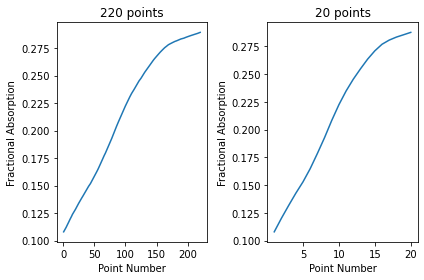

In [19]:

# mount to google drive in order to pull data file
import matplotlib.pyplot as plt
from google.colab import drive
import h5py
#drive.mount('/content/drive', force_remount=True)
#terminal = sys.stdout
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
fig, ax = plt.subplots(1,2)

ax[0].plot(list(range(1,221)), hf['spectra'][0])
ax[0].set_title("220 points")
ax[0].set_ylabel("Fractional Absorption")
ax[0].set_xlabel("Point Number")
ax[1].plot(list(range(1,21)), hf["spectra"][0][::11])
ax[1].set_title("20 points")
ax[1].set_ylabel("Fractional Absorption")
ax[1].set_xlabel("Point Number")
fig.suptitle("", y = 1.05)
fig.tight_layout()
plt.show()


In [ ]:
# import data file, splice data, split into testing and training data
def nonZeroInList(arr):
  return [[hf['atfrac_keys'][i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

subsetSize=10000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
#sample = hf["sample_id"][0:subsetSize + validationSize]

imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'])[()]
nonZeroList = [nonZeroInList(each) for each in atfrac]
spectra = np.array([x[::splicingVal] for x in spectra])
imgsNN = imgs[0:subsetSize]
spectraNN = spectra[0:subsetSize]
x_valid = imgs[subsetSize:subsetSize+validationSize]
y_valid = spectra[subsetSize:subsetSize+validationSize]
x_train, x_test, y_train, y_test = train_test_split(imgsNN, spectraNN, test_size = 0.2, random_state = None)
del imgs, spectra

In [ ]:
def nonZeroInList(arr):
  return [[hf['atfrac_keys'][i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]


file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
#sample = hf["sample_id"][0:subsetSize + validationSize]

atfrac = np.transpose(hf['atfrac'])[()]
nonZeroList = [nonZeroInList(each) for each in atfrac]

Text(156.5, 0.5, 'Metals')

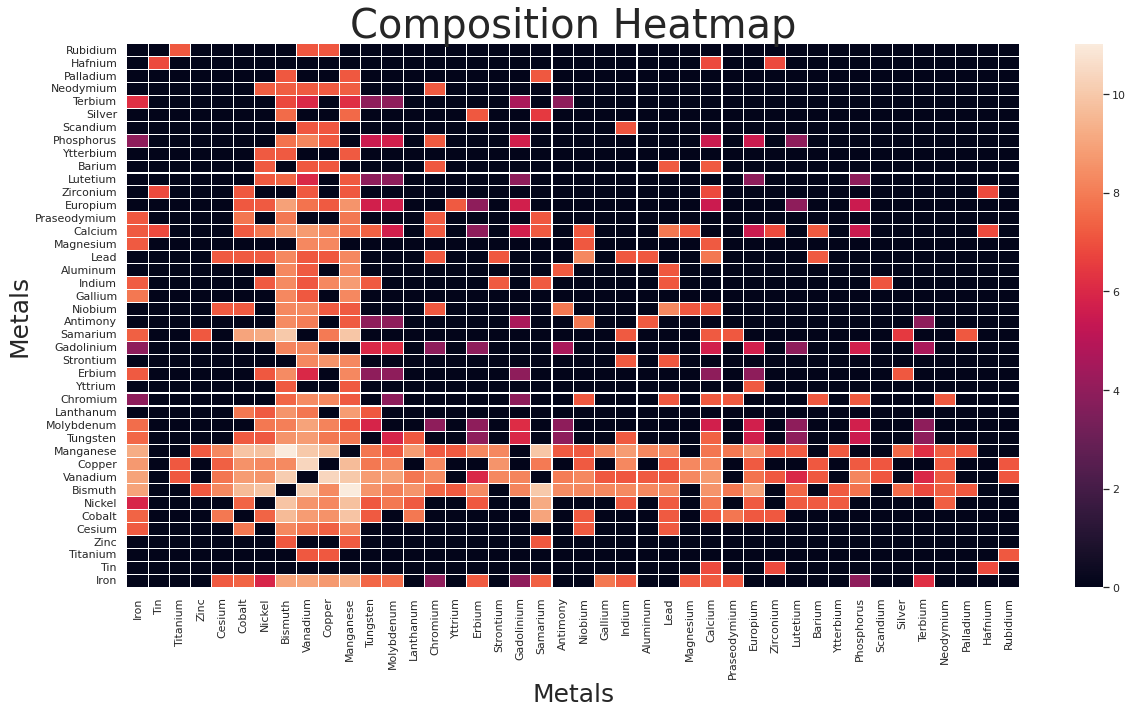

In [ ]:
from tabulate import tabulate
import seaborn as sns

atfrac_keys = hf['atfrac_keys']
oxideToOxide = {}
for i in range(len(atfrac_keys)):
  oxideToOxide[str(i)] = {}
  for j in range(len(atfrac_keys)):
    oxideToOxide[str(i)][str(j)] = 1
for nonZero in nonZeroList:
  for info in nonZero:
    currMetal = info[1]
    for otherInfo in nonZero:
      otherMetal = otherInfo[1]
      if currMetal != otherMetal:
        oxideToOxide[str(currMetal)][str(otherMetal)] += 1
      #else:
      #  oxideToOxide[str(currMetal)][str(otherMetal)] -= 1
table = []
heatmap = []
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
for i, each in enumerate(oxideToOxide.values()):
  layer = [oxides[i]] + list(each.values())
  table.append(layer)
  heatmap.append(list(each.values()))
#print(tabulate(table, headers = oxides))
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.heatmap(np.log(np.array(heatmap)), xticklabels=oxides, yticklabels=oxides, linewidths=.1)# annot = True #, fmt = 'f')
ax.invert_yaxis()
plt.title('Composition Heatmap', fontdict={'fontsize': 40})
plt.xlabel('Metals', fontdict={'fontsize': 25})
plt.ylabel('Metals', fontdict={'fontsize': 25})

Text(156.5, 0.5, 'Concentration')

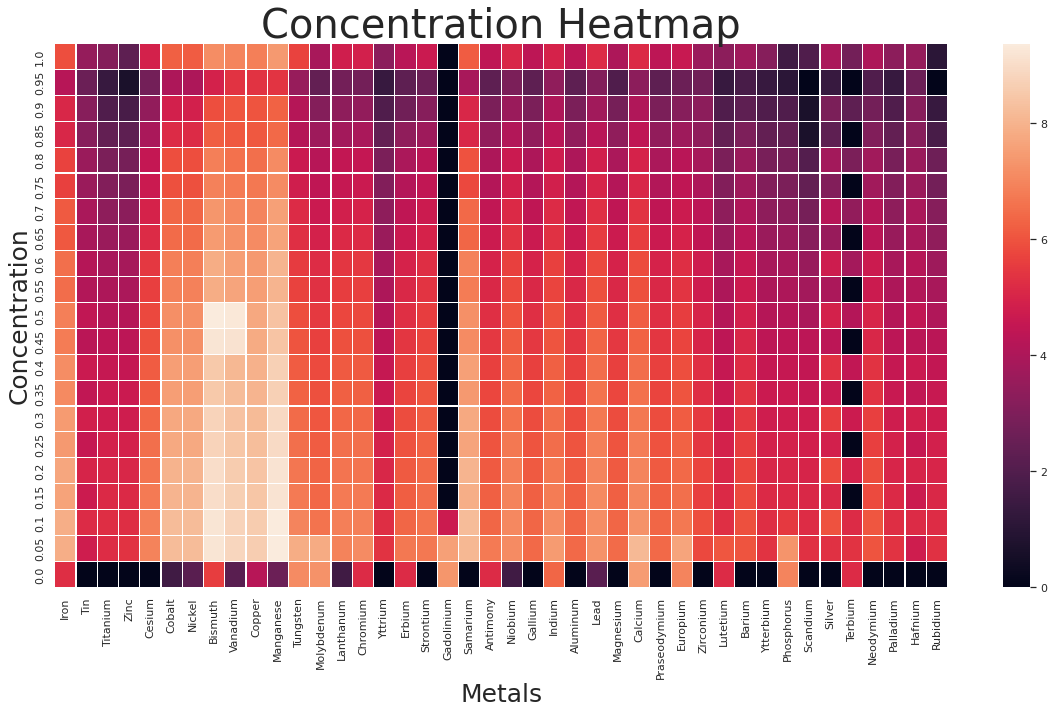

In [ ]:
from tabulate import tabulate
import seaborn as sns

def myround(x, base=.05):
    return round(base * round(x/base), 2)

oxideToConc = {}
for i in range(len(hf['atfrac_keys'])):
  oxideToConc[str(i)] = {}
  for j in [round(x * 0.05, 2) for x in range(21)]:
    oxideToConc[str(i)][str(j)] = 1
for nonZero in nonZeroList:
  for info in nonZero:
    currMetal = info[1]
    conc = myround(info[2])
    try:
      oxideToConc[str(currMetal)][str(conc)] += 1
    except:
      print(info)
table = []
heatmap = []
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
for i, each in enumerate(oxideToConc.values()):
  layer = [oxides[i]] + list(each.values())
  table.append(layer)
  heatmap.append(list(each.values()))
#print(tabulate(table, headers = ['Concentration'] + [round(x * 0.05, 2) for x in range(21)]))
sns.set(rc = {'figure.figsize':(20, 10)})
ax = sns.heatmap(np.log(np.transpose(heatmap)), xticklabels=oxides, yticklabels=[round(x * 0.05, 2) for x in range(21)], linewidths=.1) #, annot = True, fmt = 'd')
ax.invert_yaxis()
plt.title('Concentration Heatmap', fontdict={'fontsize': 40})
plt.xlabel('Metals', fontdict={'fontsize': 25})
plt.ylabel('Concentration', fontdict={'fontsize': 25})

In [ ]:
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
atfrac = np.transpose(hf['atfrac'])[()]
imgs = hf['images'][()]
indexList = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) < 1]
"""for index in indexList[0:1]:
  print(f'sum = {np.sum(imgs[index][16:48][16:48])}')
  print(f'index = {index}')
  #print(f'Composition = {nonZeroInList(atfrac[index])}')
  f, axs = plt.subplots(1,2)
  f.tight_layout()
  axs[0].imshow(imgs[index])
  axs[1].plot(spectra[index])
  plt.show()
  """
print(len(indexList))

7471


[1077, 1398, 1457, 1508, 1508, 1541, 1545, 1565, 1573, 1575, 1983, 2435, 3038, 3118, 3375, 3594, 3977, 4689, 4697, 4714, 4725, 5044, 5138, 6256, 7798, 7834, 8265, 8698, 8862, 9454, 9993, 10988, 11303, 14921, 21261, 28389, 29479, 29852, 47566, 70876, 94245, 94303]


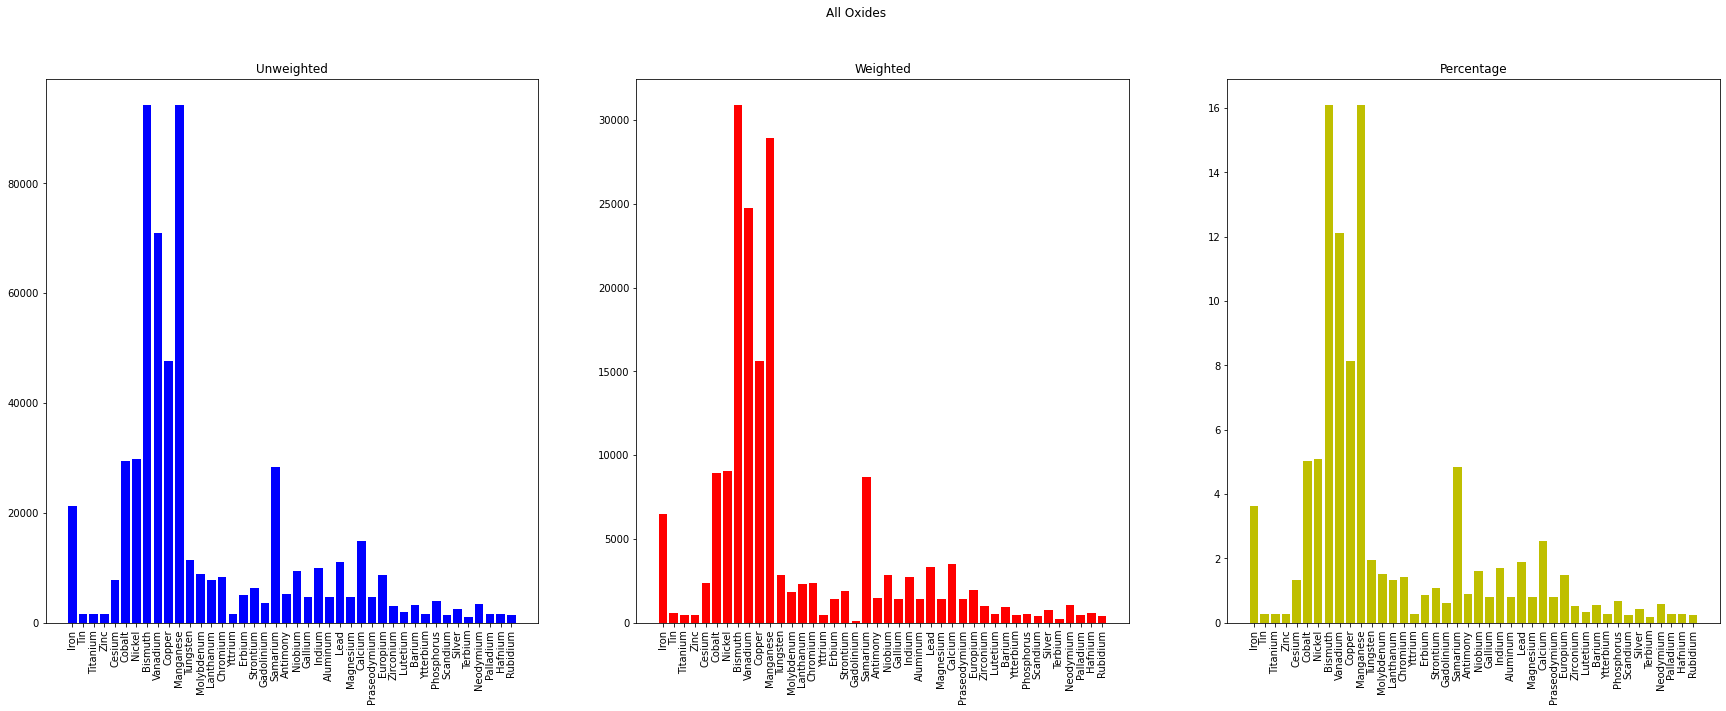

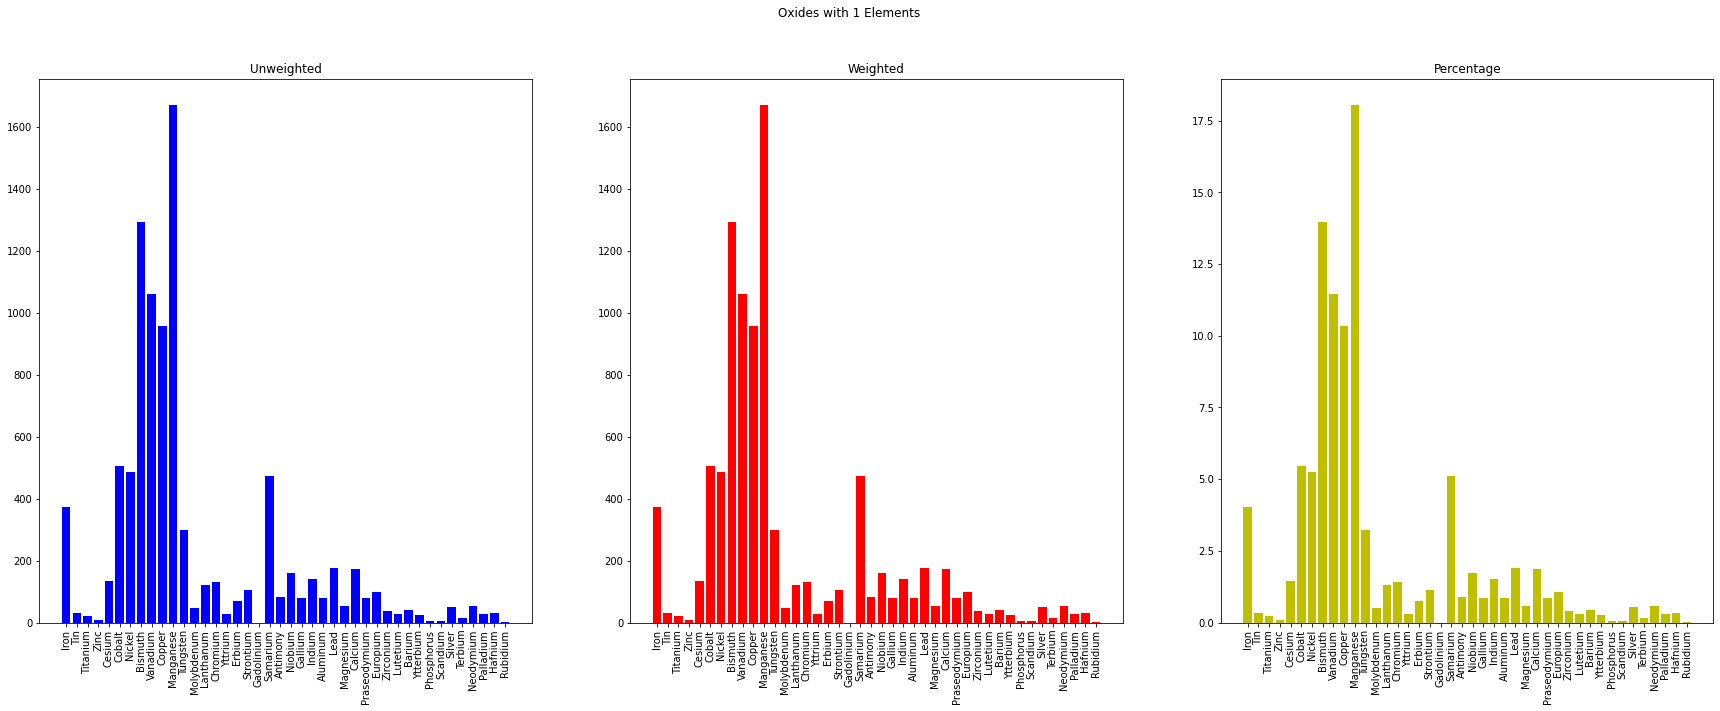

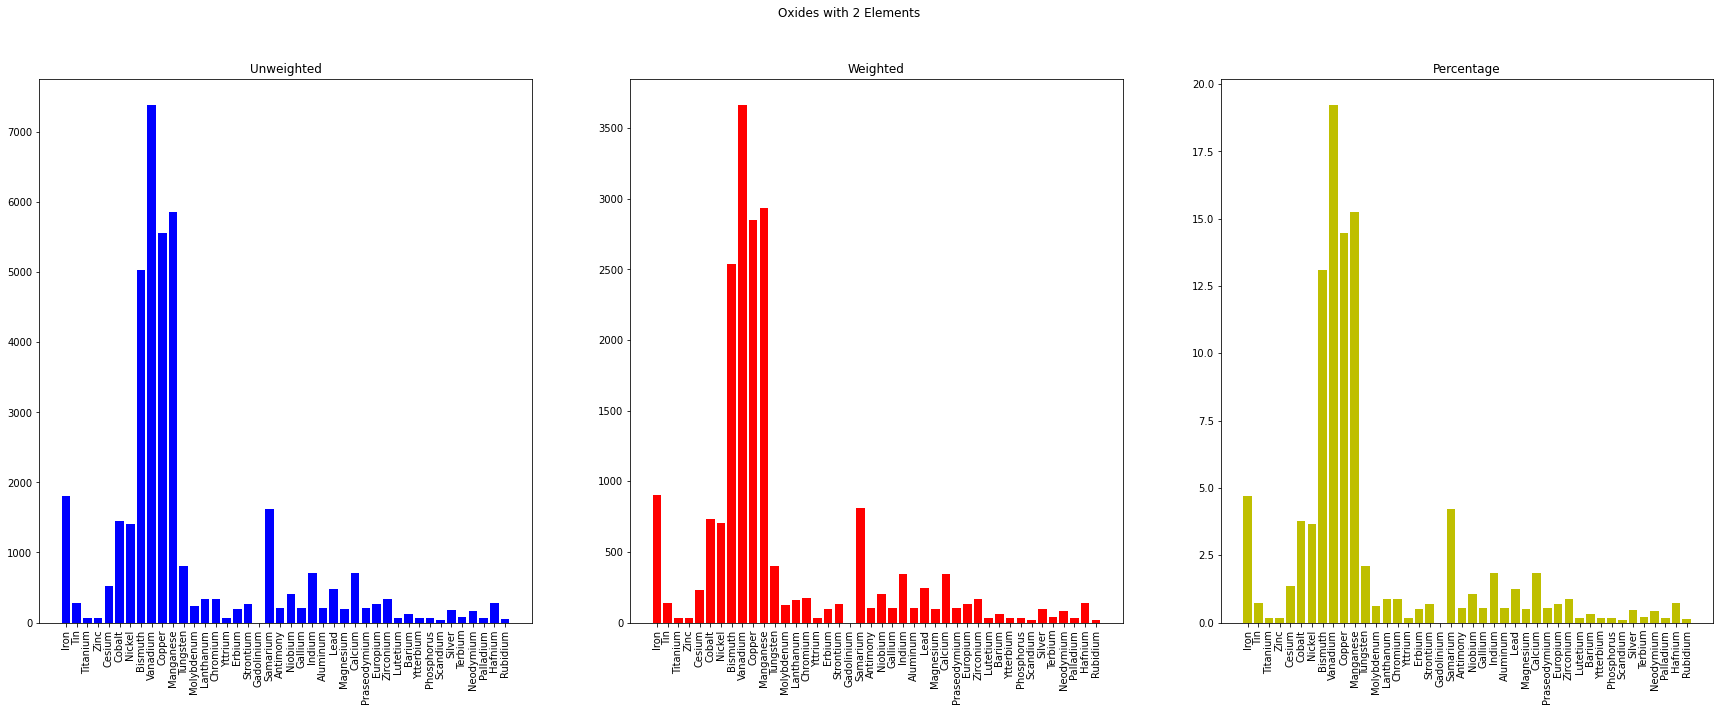

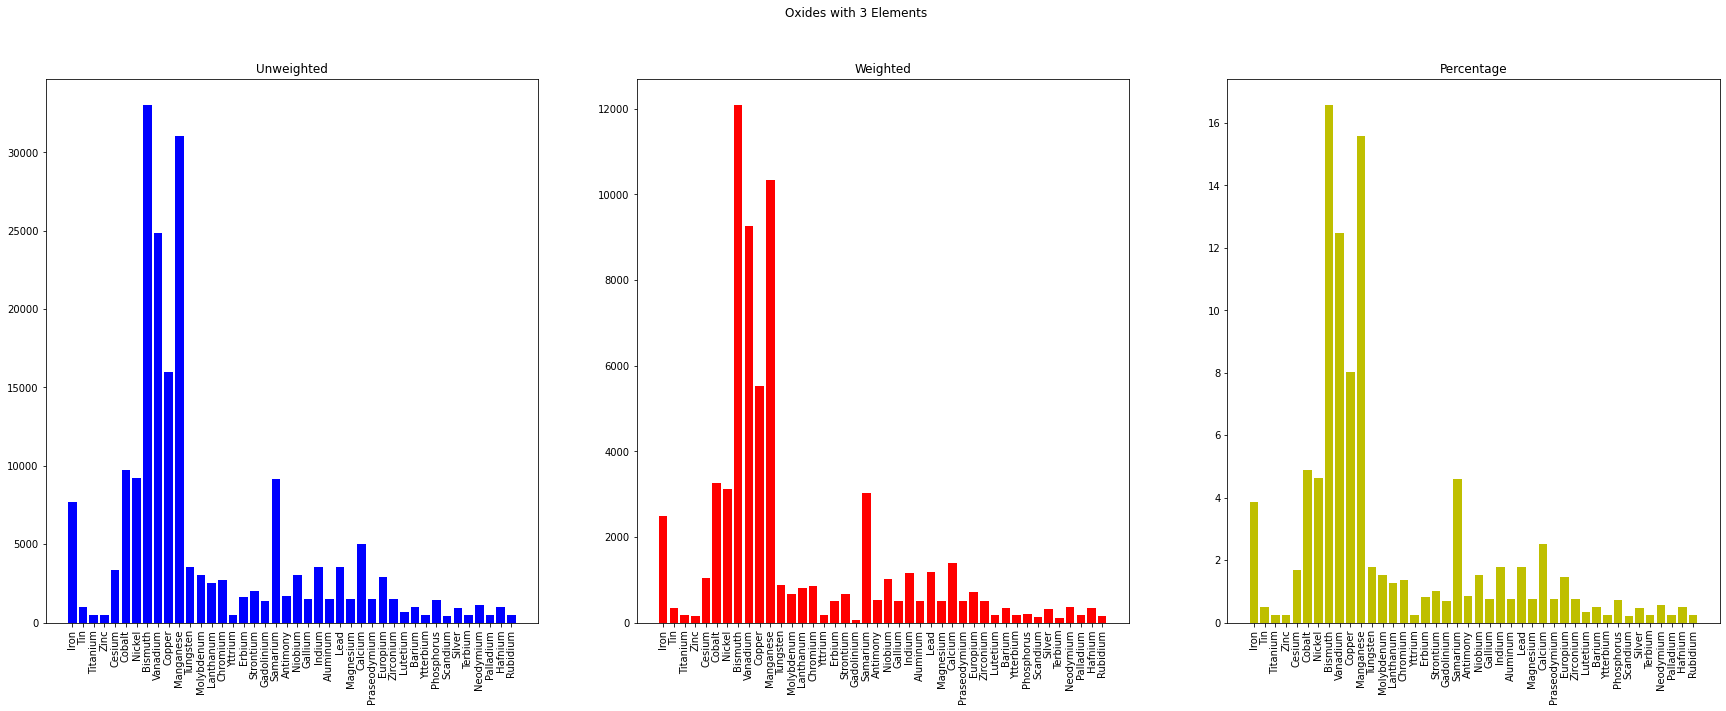

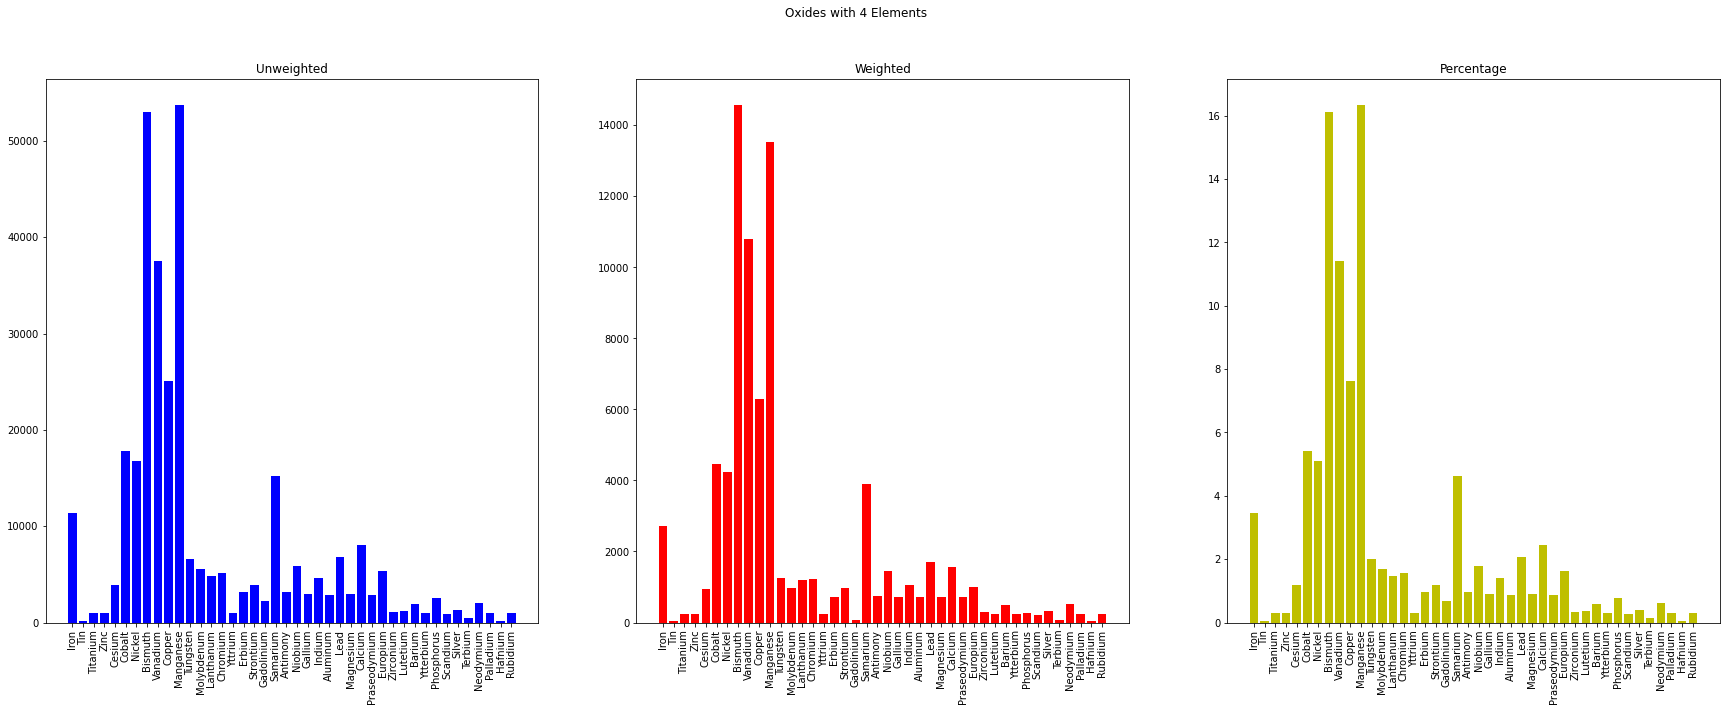

In [ ]:
for i in range(5):
  weighted = {}
  unweighted = {}
  for j in range(len(atfrac[0])):
    weighted[str(j)] = 0
    unweighted[str(j)] = 0
  temp = 0
  for ele in nonZeroList:
    if len(ele) == i or i == 0:
      for each in ele:
        unweighted[str(each[1])] += 1
        weighted[str(each[1])] += each[2]
  fig, axs = plt.subplots(1, 3, figsize=(30,10))
  if i == 0:
    fig.suptitle('All Oxides')
    print(sorted(unweighted.values()))
  else:
    fig.suptitle(f'Oxides with {i} Elements')
  #fig.tight_layout()
  x = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
  x = x.split(', ')
  y1 = unweighted.values()
  axs[0].bar(x, y1, color = 'b')
  axs[0].set_title('Unweighted')
  axs[0].set_xticklabels(x, rotation = 90)
  y2 = weighted.values()
  axs[1].bar(x, y2, color = 'r')
  axs[1].set_title('Weighted')
  axs[1].set_xticklabels(x, rotation = 90)
  y3 = 100*np.array(list(unweighted.values()))/np.sum(list(unweighted.values()))
  axs[2].bar(x, y3, color = 'y')
  axs[2].set_title('Percentage')
  axs[2].set_xticklabels(x, rotation = 90)
  plt.show()

In [ ]:
def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList

def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency

def numUnique(arr):
  count = 0
  frequency = {}
  for item in arr:
    if str(item) not in frequency:
        frequency[str(item)] = 1
        count += 1
  return count

arr = [nonZeroInList(ele) for ele in atfrac]
print(numUnique(arr))
#for key, value in frequencyOfItems(arr).items():
#  if value >= 3:
#    print(f'{key}: {value}')

100430


In [ ]:
def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList

def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency
iter = 0
oxideList = []
for index in indexList:
  metal = np.transpose(hf['atfrac'])[subsetSize + index][0:42]
  #print(iter, nonZeroInList(metal))
  oxideList.append(nonZeroInList(metal))
  iter += 1
sort = sorted(oxideList, key = lambda oxide: (oxide[0][1], len(oxide), oxide[0][2]))
for each in sort:
  print(each)
print('----')
for key, value in frequencyOfItems(sort).items():
  print(f'{key}: {value}')

NameError: ignored

In [ ]:
def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'])[()]
dic = {}

for each in atfrac:
  each = nonZeroInList(each)
  try: 
    dic[str(len(each))] += 1
  except:
    dic[str(len(each))] = 1

print(dic)

In [ ]:
def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'])[()]
indexList = [i for i, each in enumerate(atfrac) if len(nonZeroInList(each)) == 2]
for index in indexList[0:1000]:
  print(f'sum = {np.sum(imgs[index])}')
  print(f'index = {index}')
  print(f'Composition = {nonZeroInList(atfrac[index])}')
  f, axs = plt.subplots(1,2)
  f.tight_layout()
  axs[0].imshow(imgs[index])
  axs[1].plot(spectra[index])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def h5_items(file):
    for key in file:
        if isinstance(file[key], h5py.Dataset):
            print('' + key + ':' + str(file[key].shape))
        else:
            print('' + key)
            h5_items(file[key])

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
h5_items(hf)

atfrac:(42, 180902)
atfrac_keys:(42,)
energy_eV:(220,)
images:(180902, 64, 64, 3)
loading_keys:(43,)
loadings:(43, 180902)
plate_id:(180902,)
sample_id:(180902,)
spectra:(180902, 220)


In [ ]:
def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
#imgs = hf['images'][()]
#spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'])[()]
dic = {}
for i, each in enumerate(atfrac):
  each = nonZeroInList(each)
  sort = sorted(each, key = lambda x: x[2])
  if len(sort) > 0:
    max = 0
    for ele in sort:
      if ele[2] > max:
        max = ele[2]
    for ele in sort:
      if ele[2] == max:
        try:
          dic[str(ele[1])] += 1
        except:
          dic[str(ele[1])] = 1
for i in range(len(dic) + 1):
  try:
    print(i, dic[str(i)])
  except:
    print(f'{i} 0')
"""
for index in indexList:
  f, axs = plt.subplots(1,2)
  axs[0].imshow(imgs[index])
  axs[1].plot(spectra[index])
  plt.show()
"""

0 6801
1 594
2 501
3 470
4 2407
5 9586
6 9668
7 34071
8 25873
9 16746
10 30917
11 2908
12 1847
13 2446
14 2519
15 504
16 1477
17 2015
18 DNE
19 9355
20 1518
21 3032
22 1513
23 2835
24 1513
25 3526
26 1482
27 3589
28 1508
29 1998
30 1053
31 506
32 988
33 501
34 477
35 381
36 837
37 255
38 1092
39 501
40 594
41 421
[('0', 6801), ('1', 594), ('10', 30917), ('11', 2908), ('12', 1847), ('13', 2446), ('14', 2519), ('15', 504), ('16', 1477), ('17', 2015), ('19', 9355), ('2', 501), ('20', 1518), ('21', 3032), ('22', 1513), ('23', 2835), ('24', 1513), ('25', 3526), ('26', 1482), ('27', 3589), ('28', 1508), ('29', 1998), ('3', 470), ('30', 1053), ('31', 506), ('32', 988), ('33', 501), ('34', 477), ('35', 381), ('36', 837), ('37', 255), ('38', 1092), ('39', 501), ('4', 2407), ('40', 594), ('41', 421), ('5', 9586), ('6', 9668), ('7', 34071), ('8', 25873), ('9', 16746)]


'\nfor index in indexList:\n  f, axs = plt.subplots(1,2)\n  axs[0].imshow(imgs[index])\n  axs[1].plot(spectra[index])\n  plt.show()\n'

In [ ]:
for i in range(42):
  print(i, hf['atfrac_keys'][i])

0 b'Fe.PM.AtFr'
1 b'Sn.PM.AtFr'
2 b'Ti.PM.AtFr'
3 b'Zn.PM.AtFr'
4 b'Ce.PM.AtFr'
5 b'Co.PM.AtFr'
6 b'Ni.PM.AtFr'
7 b'Bi.PM.AtFr'
8 b'V.PM.AtFra'
9 b'Cu.PM.AtFr'
10 b'Mn.PM.AtFr'
11 b'W.PM.AtFra'
12 b'Mo.PM.AtFr'
13 b'La.PM.AtFr'
14 b'Cr.PM.AtFr'
15 b'Y.PM.AtFra'
16 b'Er.PM.AtFr'
17 b'Sr.PM.AtFr'
18 b'Gd.PM.AtFr'
19 b'Sm.PM.AtFr'
20 b'Sb.PM.AtFr'
21 b'Nb.PM.AtFr'
22 b'Ga.PM.AtFr'
23 b'In.PM.AtFr'
24 b'Al.PM.AtFr'
25 b'Pb.PM.AtFr'
26 b'Mg.PM.AtFr'
27 b'Ca.PM.AtFr'
28 b'Pr.PM.AtFr'
29 b'Eu.PM.AtFr'
30 b'Zr.PM.AtFr'
31 b'Lu.PM.AtFr'
32 b'Ba.PM.AtFr'
33 b'Yb.PM.AtFr'
34 b'P.PM.AtFra'
35 b'Sc.PM.AtFr'
36 b'Ag.PM.AtFr'
37 b'Tb.PM.AtFr'
38 b'Nd.PM.AtFr'
39 b'Pd.PM.AtFr'
40 b'Hf.PM.AtFr'
41 b'Rb.PM.AtFr'


In [ ]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'softsign')])
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
# Running Neural Network with averaging Ensemble

# Define number of networks, batches, and epochs 
numNetworks = 5
epochs = 30
batch_size = 32

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)
sys.stdout = open('EpochOutput.txt', 'w')
modelList = []
historyList= []
for i in range(numNetworks):
  normal_model = get_conv_model_normal()
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1)
  modelList.append(normal_model)
  historyList.append(normal_history)
sys.stdout = terminal

# Create predictions based on results of the neural network and ensemble 
def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble
def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

In [ ]:
# DO NOT RUN
# Attempted neural network for the outcomes of the ensemble, returned bad graphs so scratched for now, may implement later

def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, numOutputs)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation='softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = [metrics.mean_squared_logarithmic_error, metrics.mean_absolute_percentage_error]))
    return model

# fixed input parameters
modelInput = makePredictionsList(modelList, x_train)
modelInput = np.transpose(modelInput, (1, 0, 2))

sys.stdout = open('EpochOutput2.txt', 'w') 
epochs = 50
batch_size = 64
x_train2, x_test2, y_train2, y_test2 = train_test_split(modelInput, spectra, test_size = 0.2, random_state = None)
final_model = get_model_from_ensemble()
final_history = final_model.fit(x_train2, y_train2, batch_size = batch_size,
              epochs = epochs, validation_data = (x_test2, y_test2), verbose = 1)
sys.stdout = terminal

# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our final neural network ensemble model

# MSLE
plt.plot(final_history.history['mean_squared_logarithmic_error'], label='MSLE training data')
plt.plot(final_history.history['val_mean_squared_logarithmic_error'], label='MSLE validation data')
plt.legend()
plt.title('Mean Squared Logarithmic Error Over Time')
plt.ylabel('MSLE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMSLE.jpg')
plt.show()

# MAPE
plt.plot(final_history.history['mean_absolute_percentage_error'], label='MAPE training data')
plt.plot(final_history.history['val_mean_absolute_percentage_error'], label='MAPE validation data')
plt.legend()
plt.title('Mean Absolute Percentage Error Over Time')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMAPE.jpg')
plt.show()

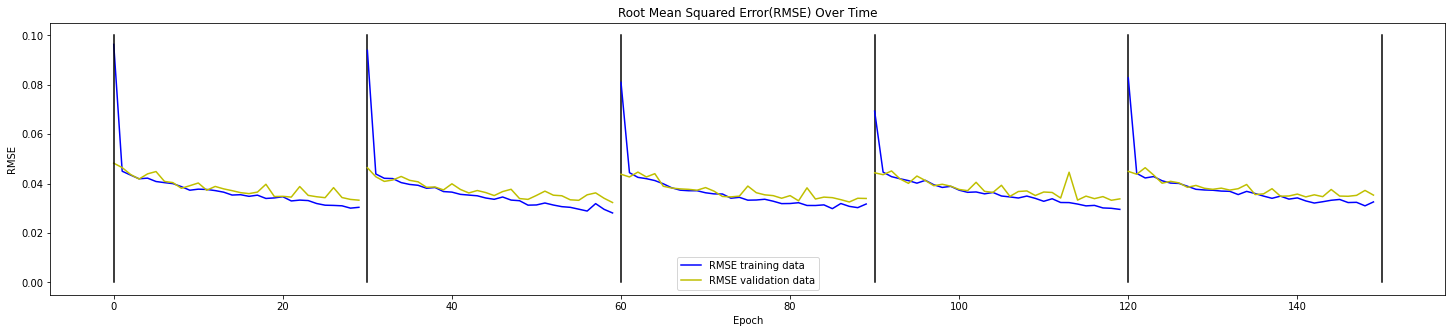

In [ ]:
# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our neural network ensemble model

# RMSE
fig = plt.figure(figsize=(25, 5))
for i, normal_history in enumerate(historyList):
  x = np.array([x for x in range(epochs)])
  plt.plot(x + epochs*i, normal_history.history['root_mean_squared_error'], color = 'b')
  plt.plot(x + epochs*i, normal_history.history['val_root_mean_squared_error'], color = 'y')
  plt.plot([epochs*(i+1),epochs*(i+1)],[0,.1], color='black')
  plt.title('Root Mean Squared Error(RMSE) Over Time')
  plt.ylabel('RMSE')
  plt.xlabel('Epoch')
plt.legend(['RMSE training data', 'RMSE validation data'])
plt.savefig('RMSE_Plot.jpg')
plt.plot([0,0],[0,.1], color = 'black')
plt.show()


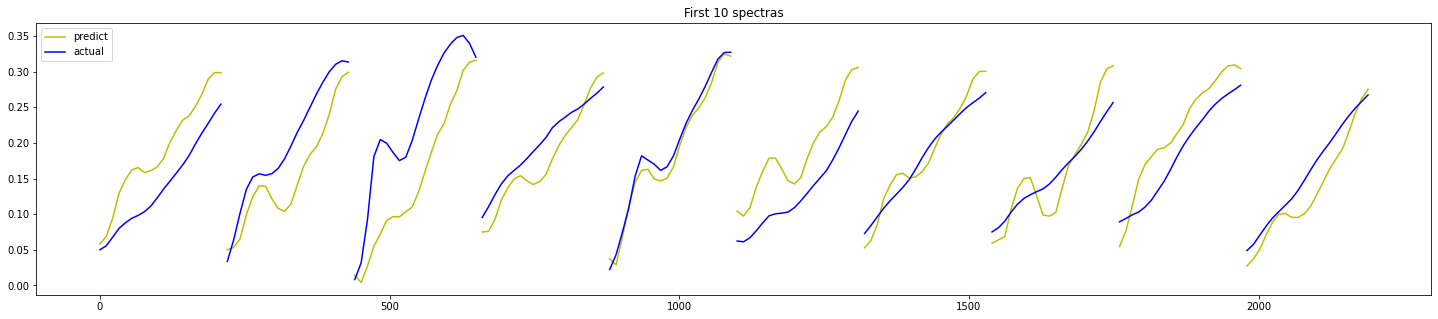

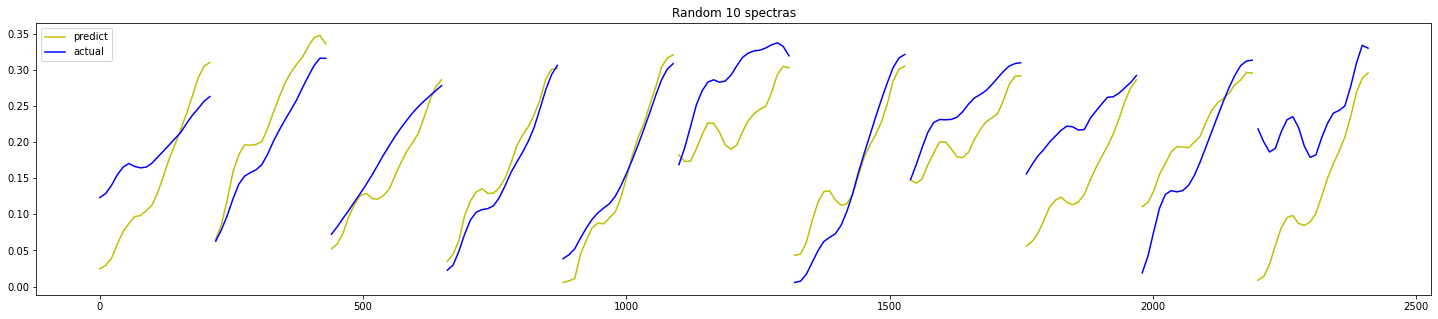

In [ ]:
# Plots first 10 spectra images on a single graph
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'y')
  plt.plot(x + 220*i, y_test[i], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.title('First 10 spectras')
plt.savefig('First10.jpg')
plt.show()

# Plots random 10 spectra images on a single graph
rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'y')
  plt.plot(x + 220*i, y_test[rand], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
  i+=1
plt.title('Random 10 spectras')
plt.savefig('Random10.jpg')
plt.show()

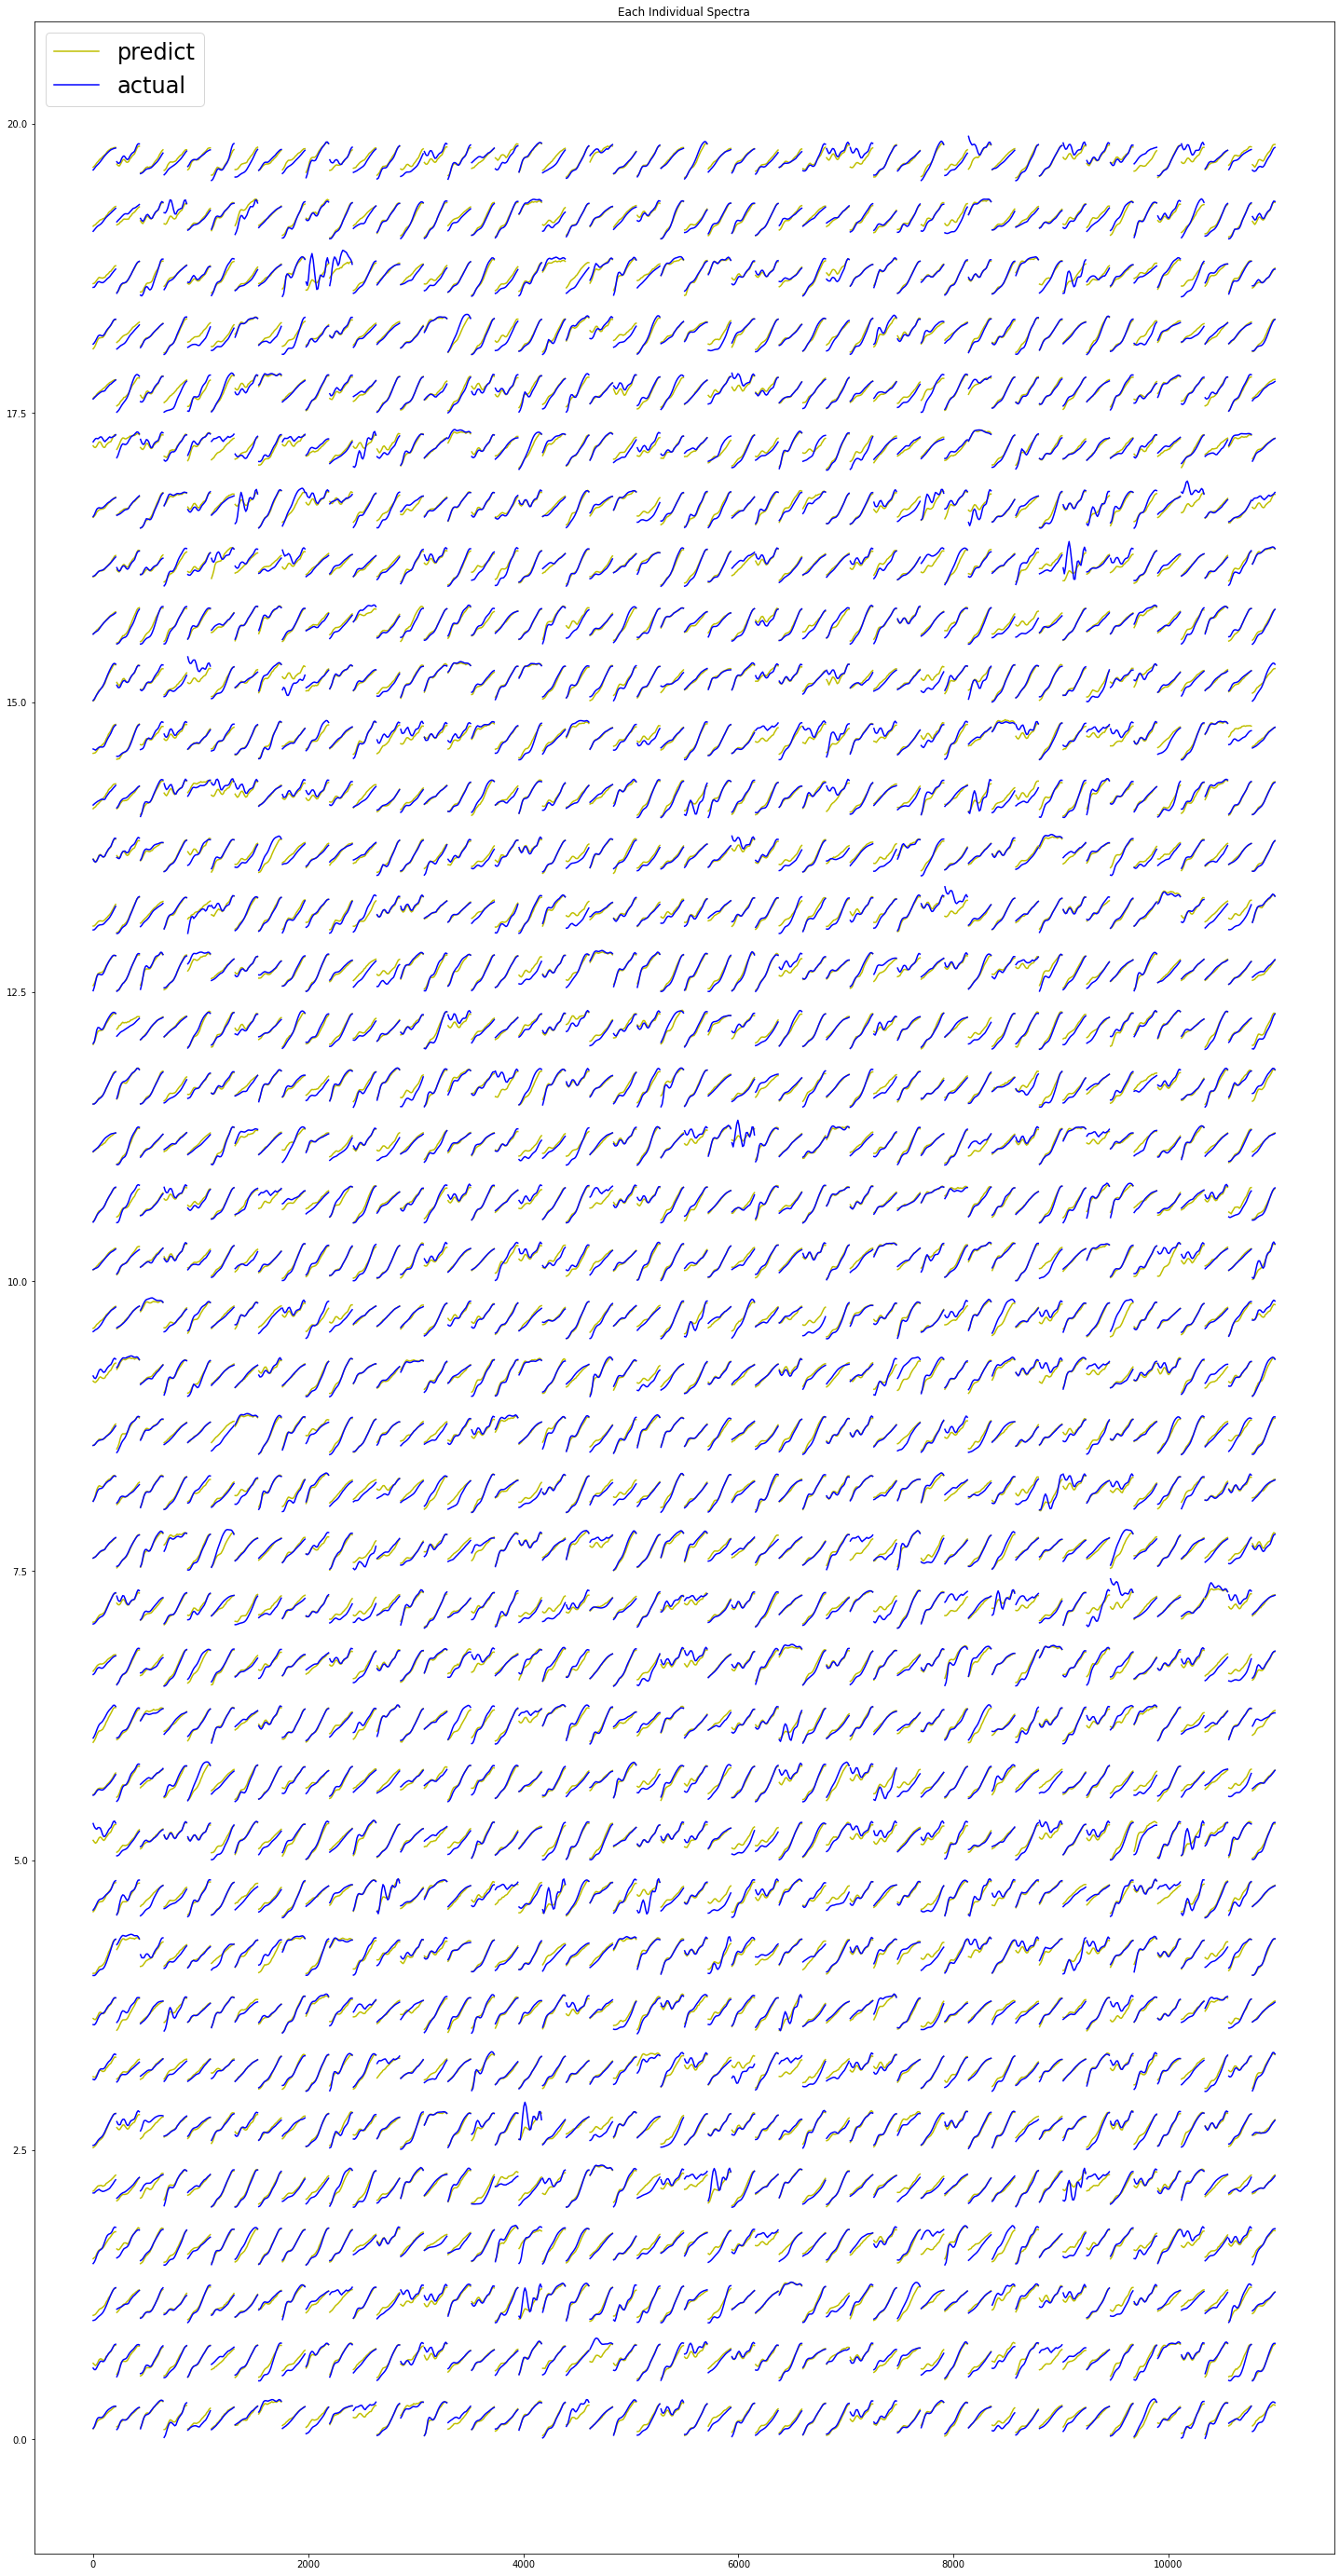

In [ ]:
# Creates Grid of All Spectras in Testing set

def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_test)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]
fig = plt.figure(figsize=(25, 50))
low, high = closest_factor(len(x_test))
for j in range(low):
  for i in range(high):
    plt.plot(x + 220*i, y[50*j+i]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_test[50*j+i]+.5*j, color = 'b')
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Each Individual Spectra')
plt.savefig('EverySpectra.jpg')
plt.show()

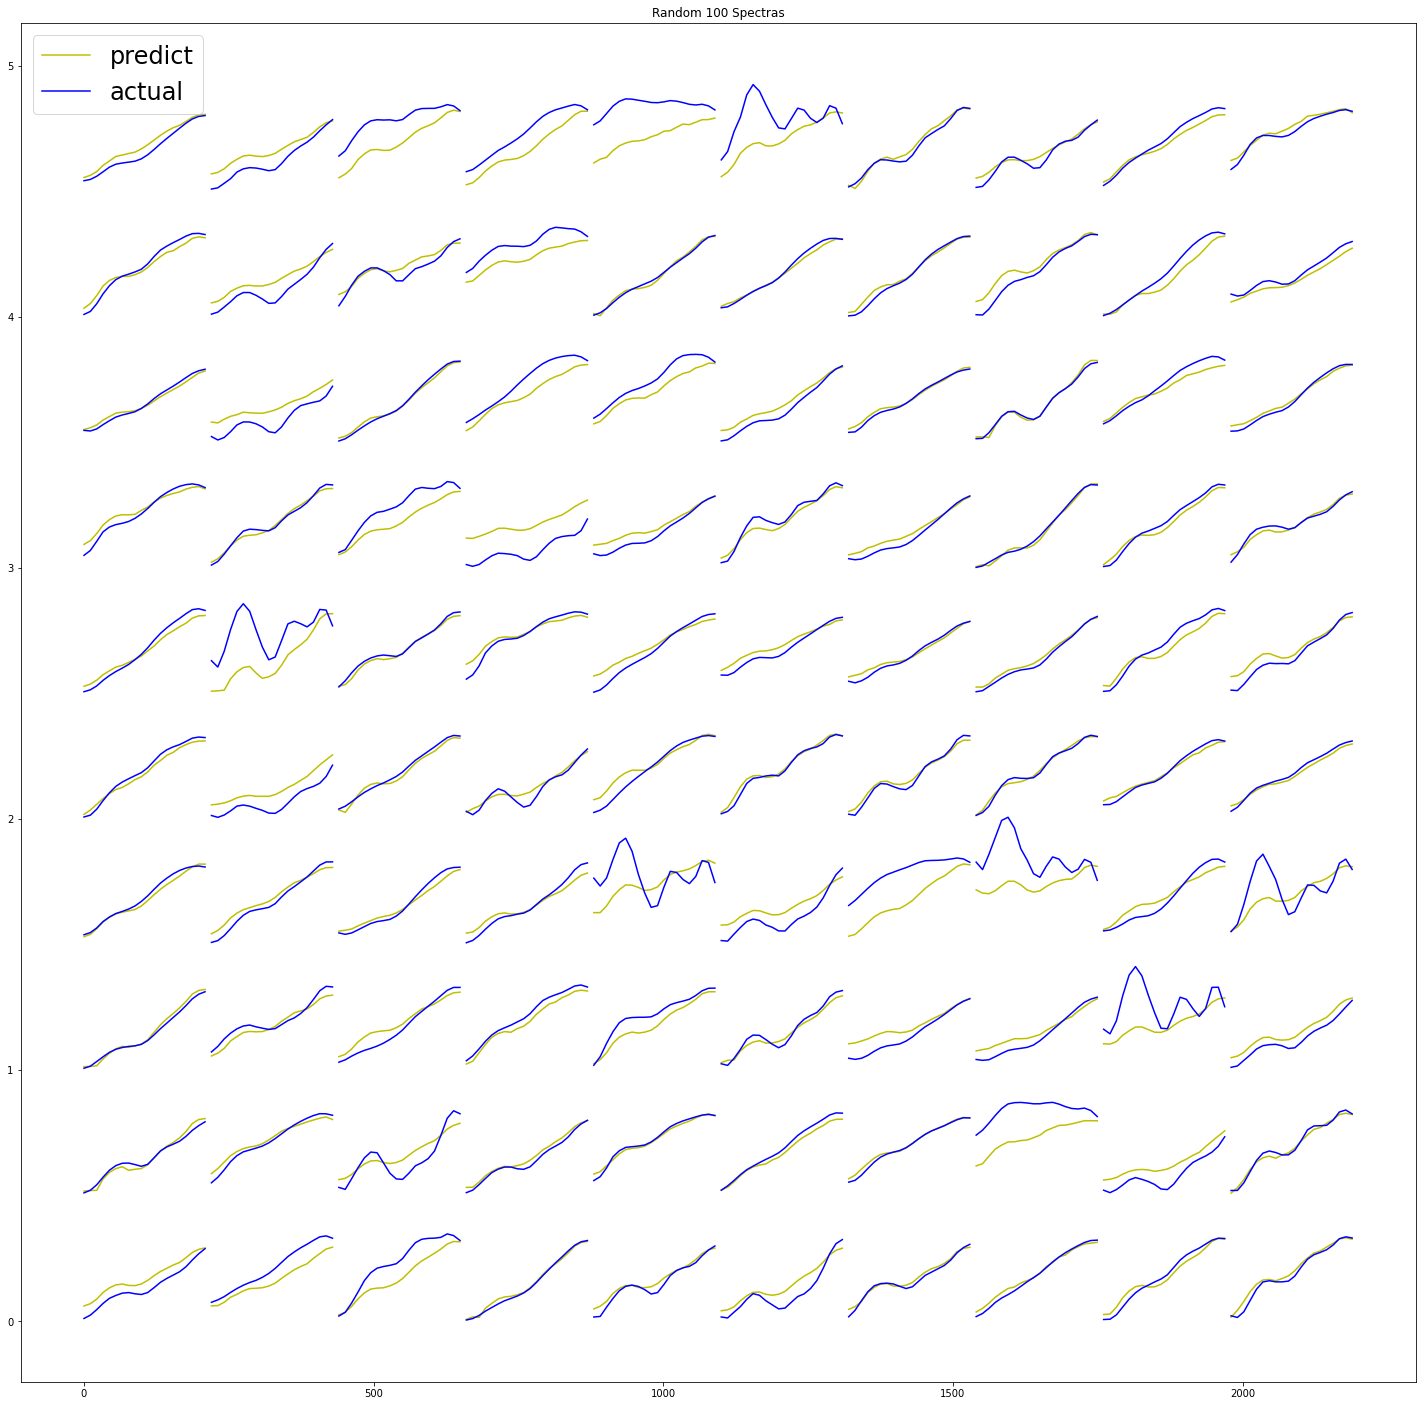

In [ ]:
# Creates Random 100 Grid of Spectras from Validation Data
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'b')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras')
plt.savefig('100Grid.jpg')
plt.show()

In [ ]:
# Make Error graph
from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
#color = []
#for i in range(numOutputs):
#  rando = [x/(10*numOutputs) for x in range(10)]
#  random.shuffle(rando)
#  temp = i/numOutputs
#  color.append((temp+rando[0],temp+rando[1], temp+rando[2]))
for i in range(numOutputs):
  #color = i/numOutputs
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')#(color, color, color))
a, b = 0, .4 
plt.plot([a,b],[a,b], color='black')
plt.title('Symmetric Error Graph')
plt.xlabel('y actual')
plt.ylabel('y predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.425, 0.4, f"R^2 = {round(r2_score(y_pred, y_valid), 5)}", fontdict = font)
plt.savefig('SymError.jpg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

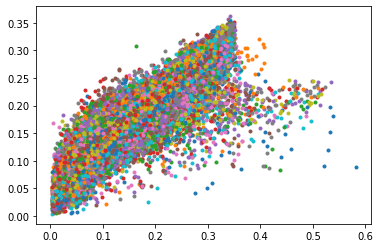

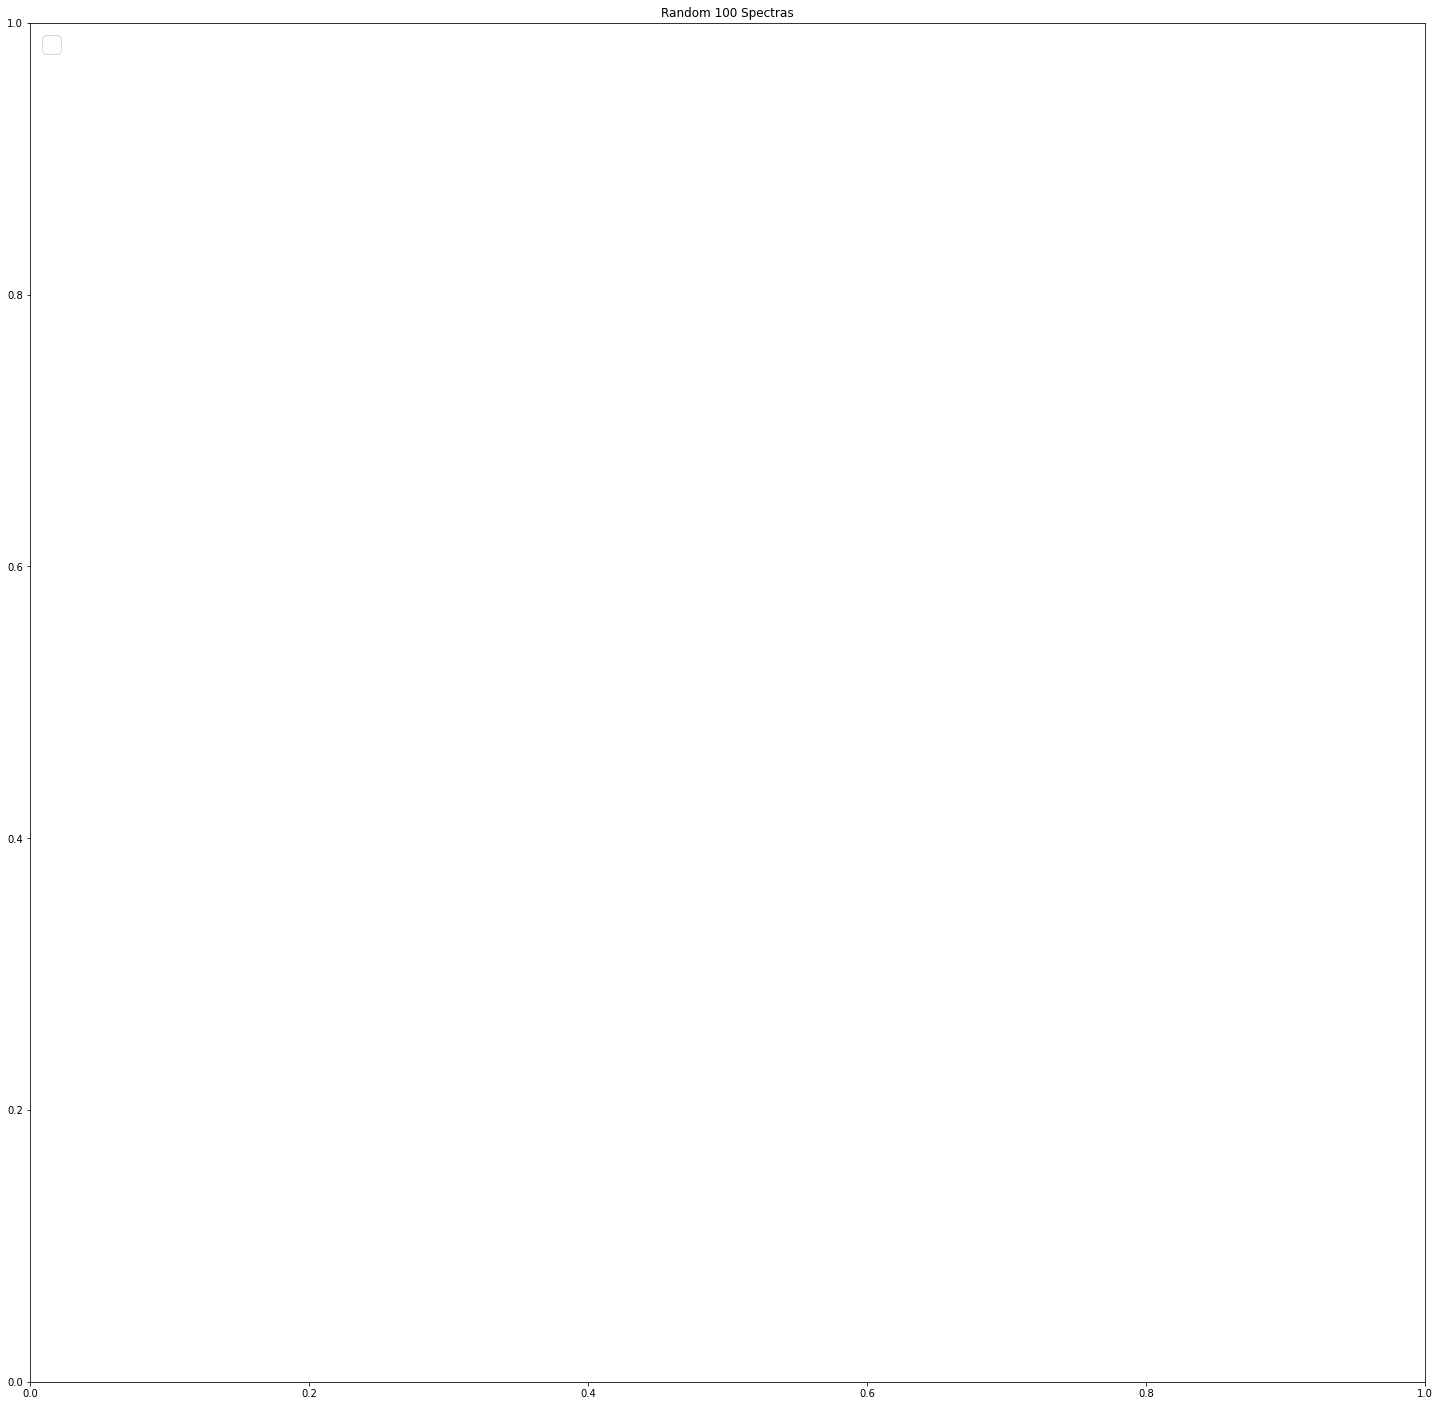

In [ ]:
bad = []
y = []
indexList = []
for i, ele in enumerate(y_valid):
  if max(ele) >= .4:
    bad.append(y_pred[i])
    y.append(ele)
    indexList.append(i)
# Creates Random 100 Grid of Spectras from Validation Data
x = np.array([x for x in range(0,220,splicingVal)])
fig = plt.figure(figsize=(25, 25))
#low, high = closest_factor(len(bad))
for j in range(10):
  for i in range(10):
    try:
      plt.plot(x + 220*i, bad[i+10*j]+.5*j, color = 'y')
      plt.plot(x + 220*i, y[i+10*j]+.5*j, color = 'b')
    except: 
      break
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras')
plt.savefig('100Grid.jpg')
plt.show()


In [ ]:
def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList
def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency
iter = 0
oxideList = []
for index in indexList:
  metal = np.transpose(hf['atfrac'])[subsetSize + index][0:42]
  #print(iter, nonZeroInList(metal))
  oxideList.append(nonZeroInList(metal))
  iter += 1
sort = sorted(oxideList, key = lambda oxide: (oxide[0][1], len(oxide), oxide[0][2]))
for each in sort:
  print(each)
print('----')
for key, value in frequencyOfItems(sort).items():
  print(f'{key}: {value}')

[[b'V.PM.AtFra', 8, 0.05], [b'Nd.PM.AtFr', 38, 0.95]]
[[b'V.PM.AtFra', 8, 0.2], [b'Nd.PM.AtFr', 38, 0.8]]
[[b'V.PM.AtFra', 8, 0.2], [b'Nd.PM.AtFr', 38, 0.8]]
[[b'V.PM.AtFra', 8, 0.3], [b'Nd.PM.AtFr', 38, 0.7]]
[[b'V.PM.AtFra', 8, 0.35], [b'Nd.PM.AtFr', 38, 0.65]]
[[b'V.PM.AtFra', 8, 0.4], [b'Nd.PM.AtFr', 38, 0.6]]
[[b'V.PM.AtFra', 8, 0.5], [b'Nd.PM.AtFr', 38, 0.5]]
[[b'V.PM.AtFra', 8, 0.6], [b'Nd.PM.AtFr', 38, 0.4]]
[[b'V.PM.AtFra', 8, 0.8], [b'Cu.PM.AtFr', 9, 0.2]]
[[b'V.PM.AtFra', 8, 0.85], [b'Cu.PM.AtFr', 9, 0.15]]
[[b'V.PM.AtFra', 8, 0.9], [b'Cu.PM.AtFr', 9, 0.1]]
[[b'V.PM.AtFra', 8, 0.05], [b'Cu.PM.AtFr', 9, 0.1], [b'Nd.PM.AtFr', 38, 0.85]]
[[b'V.PM.AtFra', 8, 0.05], [b'Cu.PM.AtFr', 9, 0.75], [b'Nd.PM.AtFr', 38, 0.2]]
[[b'V.PM.AtFra', 8, 0.25], [b'Cu.PM.AtFr', 9, 0.05], [b'Nd.PM.AtFr', 38, 0.7]]
[[b'V.PM.AtFra', 8, 0.7], [b'Cu.PM.AtFr', 9, 0.25], [b'Nd.PM.AtFr', 38, 0.05]]
[[b'V.PM.AtFra', 8, 0.75], [b'Cu.PM.AtFr', 9, 0.15], [b'Nd.PM.AtFr', 38, 0.1]]
[[b'V.PM.AtFra', 8, 0.85], [b'

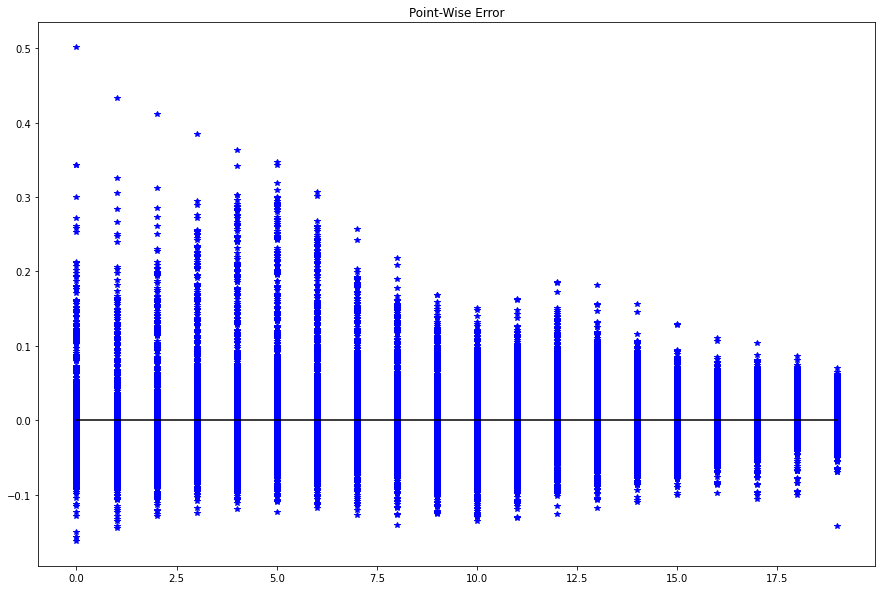

In [ ]:
#Make error graph 2
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(y_valid[i] - y_pred[i], '*', color = 'b')
plt.plot([0, numOutputs - 1],[0,0], color = 'black')
plt.title('Point-Wise Error')
plt.savefig('PointWiseError.jpg')
plt.show()

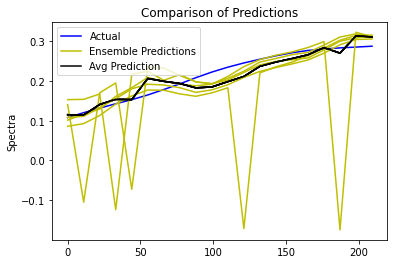

In [ ]:
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
plt.plot(x,spectra[0], color = 'b')
for predict in predictList:
  plt.plot(x, predict[0], color = 'y')
  plt.plot(x,y[0], color = 'black')
plt.legend(['Actual', 'Ensemble Predictions', 'Avg Prediction'], loc = 'upper left')
plt.title('Comparison of Predictions')
plt.ylabel('Spectra')
plt.savefig('PredictCompare.jpg')
plt.show()

In [ ]:
# Various error functions to use
y0 = y_test
predictList = makePredictionsList(modelList, x_test)
y1 = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]

dy = y0-y1 # error 
abs_dy = np.abs(y0-y1)    # absolute error 
relerr = np.abs(y0-y1)/y0   # relative error 
pererr = np.abs(y0-y1)/y0*100    # percentage error 
mean_err = np.mean(np.abs(y0-y1))     # mean absolute error 
MSE = np.mean((y0-y1)**2)        # Mean square error 
RMSE = np.sqrt(np.mean((y0-y1)**2))  # Root mean square error

In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['EpochOutput.txt', 'First10.jpg', 'Random10.jpg', 'ModelAccuracyMSLE.jpg', 'ModelAccuracyMAPE.jpg', 'PredictCompare.jpg', '100Grid.jpg', 'EverySpectra.jpg']
for name in names:
  colab_link = name
  gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
  shutil.copy(colab_link, gdrive_link)

In [ ]:
# DO NOT RUN
# Plots First 10 predictions all on the same graph
# Only use if you need to investigate oscillations in spectra graphs
# Must add 'AllPredictions.jpg' to saving code block for this image to save

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')    
  plt.legend(['predict'], loc='upper left')  
plt.savefig('AllPredictions.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Attempt to implement Custom Loss Function, still a work in progress

def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
# DO NOT RUN 
# Use this only if we want to load an already built model
normal_model = load_model('Model.h5')

OSError: ignored